In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x



In [ ]:
class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x



In [ ]:

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


In [ ]:

class Unet(nn.Module):

 def __init__(self, in_channels, classes, first_out_channels=64):
  super(Unet, self).__init__()
  self.n_channels = in_channels
  self.n_classes =  classes
  self.nc = first_out_channels
  self.nc2 = 2 * self.nc
  self.nc4 = 4 * self.nc
  self.nc8 = 8 * self.nc

  self.inc = InConv(in_channels, self.nc)
  self.down1 = Down(self.nc, self.nc2)
  self.down2 = Down(self.nc2, self.nc4)
  self.down3 = Down(self.nc4, self.nc8)
  self.down4 = Down(self.nc8, self.nc8)
  self.up1 = Up(2*self.nc8, self.nc4)
  self.up2 = Up(self.nc8, self.nc2)
  self.up3 = Up(self.nc4, self.nc)
  self.up4 = Up(self.nc2, self.nc)
  self.outc = OutConv(self.nc, classes)

 def forward(self, x):
  x1 = self.inc(x)
  x2 = self.down1(x1)
  x3 = self.down2(x2)
  x4 = self.down3(x3)
  x5 = self.down4(x4)
  x = self.up1(x5, x4)
  x = self.up2(x, x3)
  x = self.up3(x, x2)
  x = self.up4(x, x1)
  x = self.outc(x)
  return nn.Sigmoid()(x)


In [ ]:

# UNet model creation:
net = Unet(3, 1).to(device)

In [ ]:
import copy
import cv2
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import torchvision
import torchvision.transforms as transforms
import torchvision.utils

from zipfile import ZipFile



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
use_pre_trained = True # True - load the model already trained and saved, False - train the model
"""
When save_input_classes = True and save_train_test_splitting = True,
the initial splitting of the data into training and test sets is performed.
"""
save_input_classes = False
save_train_test_splitting = False

In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/'
CURR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/'

FILE_NAME = CURR_PATH + 'model_seg_pytorch_medicalunet.cnn'   # to save the model check-points during the training
FILE_NAME_PR = CURR_PATH + 'model_seg_pytorch_medicalunet.cnn_23' # the pre-trained model

r_size = 256
batch_size = 16
ep_num = 15

zip_name = 'ISSBI2015.zip'

In [ ]:
with ZipFile(DATA_PATH + zip_name, 'r') as f:
    names = f.namelist()

len(names), names[10]

(7608, 'ISSBI2015/training1/training01_01_flair_pp_slice_101+mask.tiff')

In [ ]:
names = [n.split('/')[-1] for n in names]
names = list(filter(lambda x: (x != '' and x != 'data.csv' and x != 'README.md'), names))
names[0], len(names)

('training01_01_flair_pp_slice_0+mask.tiff', 7602)

In [ ]:
f_names = [ 'ISSBI2015/' + n[:8]+n[9] + '/' + n for n in names]
f_names[0]

'ISSBI2015/training1/training01_01_flair_pp_slice_0+mask.tiff'

In [ ]:
f_images = list(filter(lambda x: 'mask' not in x, f_names))
f_images[0], len(f_images)

('ISSBI2015/training1/training01_01_flair_pp_slice_0.tiff', 3801)

In [ ]:
f_masks = list(filter(lambda x: 'mask' in x, f_names))
f_masks[0], len(f_masks)

('ISSBI2015/training1/training01_01_flair_pp_slice_0+mask.tiff', 3801)

In [ ]:
del f_names
del f_masks

In [ ]:
def show_input_sample(f_images):
    random.shuffle(f_images)
    with ZipFile(DATA_PATH + zip_name) as archive:
        data = archive.read(f_images[0])
        print(f_images[0][:-5] + '+mask.tiff')
        data1 = archive.read(f_images[0][:-5] + '+mask.tiff')

    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    print(mask.max(), mask.min(), np.unique(mask))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img)
    axes[1].imshow(mask)
    plt.show()

ISSBI2015/training3/training03_02_flair_pp_slice_151+mask.tiff
0 0 [0]


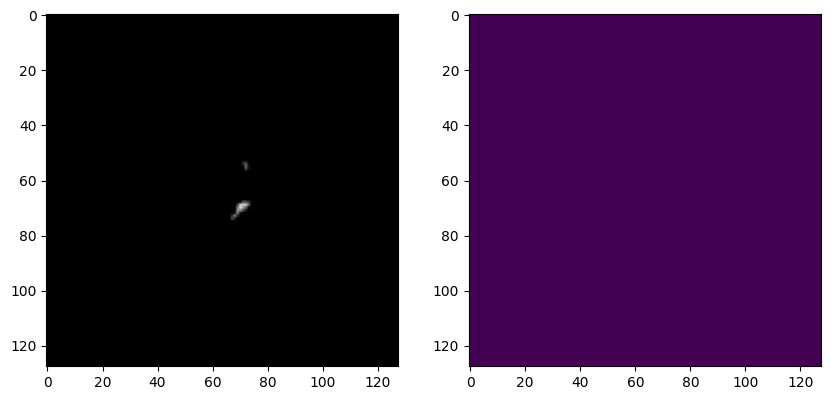

In [ ]:
show_input_sample(f_images)

In [ ]:
if save_input_classes:
    f_images0 = []
    f_images1 = []

    for f in f_images:
        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(f)
            print(f[:-5] + '+mask.tiff')
            data1 = archive.read(f[:-5] + '+mask.tiff')

            mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      #      print(mask.max(),mask.min(),np.unique(mask))
            if mask.max() < 127:
                f_images0.append(f)
            else:
                f_images1.append(f)

    with open(DATA_PATH + "fN_im0.txt", "w") as fl:
        for f in f_images0:
            fl.write(f + '\n')

    with open(DATA_PATH + "fN_im1.txt", "w") as fl:
        for f in f_images1:
            fl.write(f + '\n')

ISSBI2015/training3/training03_02_flair_pp_slice_151+mask.tiff
ISSBI2015/training4/training04_02_flair_pp_slice_39+mask.tiff
ISSBI2015/training5/training05_04_flair_pp_slice_131+mask.tiff
ISSBI2015/training2/training02_03_flair_pp_slice_173+mask.tiff
ISSBI2015/training2/training02_01_flair_pp_slice_102+mask.tiff
ISSBI2015/training4/training04_02_flair_pp_slice_95+mask.tiff
ISSBI2015/training2/training02_02_flair_pp_slice_110+mask.tiff
ISSBI2015/training3/training03_05_flair_pp_slice_63+mask.tiff
ISSBI2015/training3/training03_03_flair_pp_slice_115+mask.tiff
ISSBI2015/training1/training01_01_flair_pp_slice_51+mask.tiff
ISSBI2015/training4/training04_04_flair_pp_slice_94+mask.tiff
ISSBI2015/training5/training05_03_flair_pp_slice_20+mask.tiff
ISSBI2015/training2/training02_03_flair_pp_slice_77+mask.tiff
ISSBI2015/training1/training01_02_flair_pp_slice_70+mask.tiff
ISSBI2015/training1/training01_01_flair_pp_slice_98+mask.tiff
ISSBI2015/training4/training04_04_flair_pp_slice_110+mask.tiff
I

In [ ]:
with open(DATA_PATH + "fN_im0.txt", "r") as fl:
    f_images0 = fl.readlines()

f_images0 = [f.strip() for f in f_images0]

with open(DATA_PATH + "fN_im1.txt", "r") as fl:
    f_images1 = fl.readlines()

f_images1 = [f.strip() for f in f_images1]

In [ ]:
len(f_images0), len(f_images1)

(2236, 1565)

ISSBI2015/training2/training02_04_flair_pp_slice_49+mask.tiff
255 0 [  0 255]


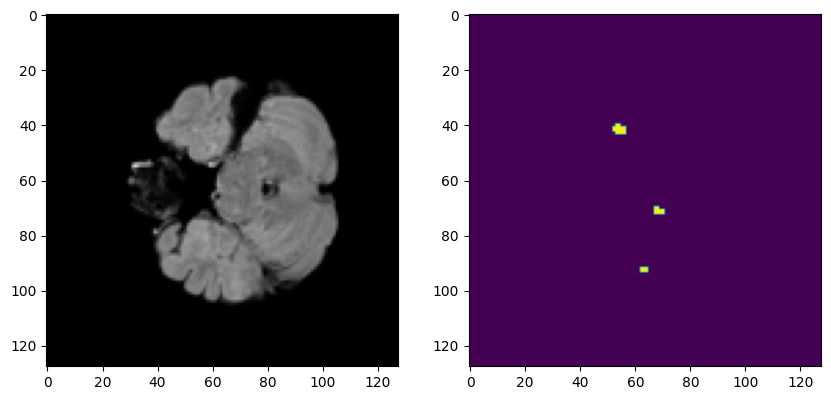

In [ ]:
show_input_sample(f_images1)

ISSBI2015/training3/training03_05_flair_pp_slice_156+mask.tiff
0 0 [0]


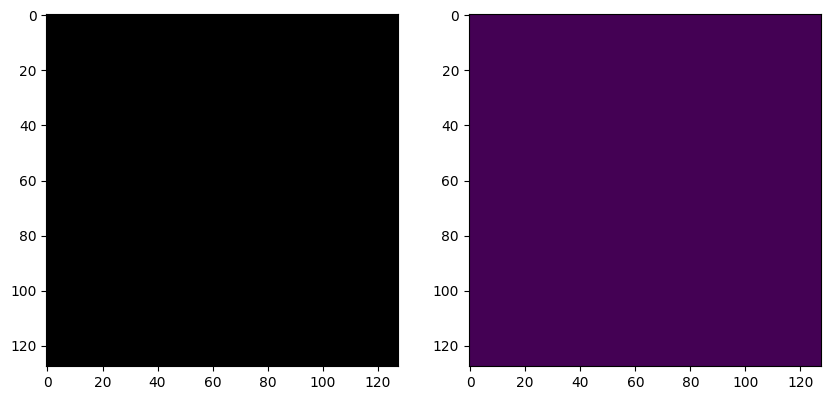

In [ ]:
show_input_sample(f_images0)

In [ ]:
if save_train_test_splitting:
    random.shuffle(f_images0)
    train_len0 = int(0.9 * len(f_images0))
    df_train0 = f_images0[:train_len0]
    df_test0 = f_images0[train_len0:]

    random.shuffle(f_images1)
    train_len1 = int(0.9 * len(f_images1))
    df_train1 = f_images1[:train_len1]
    df_test1 = f_images1[train_len1:]

    #To make a balanced training dataset:

    diff = len(df_train0) - len(df_train1)
    random.shuffle(df_train1)
    df_train1.extend(df_train1[:diff])

    df_train = df_train0
    df_test = df_test0

    df_train.extend(df_train1)
    df_test.extend(df_test1)

    with open(DATA_PATH + 'dfN_train.txt', 'w') as fl:
        for f in df_train0:
            fl.write(f + '\n')

    with open(DATA_PATH + 'dfN_test.txt', 'w') as fl:
        for f in df_test0:
            fl.write(f + '\n')

In [ ]:
with open(DATA_PATH + 'dfN_train.txt', 'r') as fl:
    df_train = fl.readlines()
df_train = [f.strip() for f in df_train]

with open(DATA_PATH + 'dfN_test.txt', 'r') as fl:
    df_test = fl.readlines()
df_test = [f.strip() for f in df_test]

print(len(df_train))
print(len(df_test))

4024
381


In [ ]:
# just to verify that the test data is not included in the training set
for dl in df_test:
    if dl in df_train:
        print('test line in the train set!!!')

In [ ]:
class SegmentDataset(Dataset):
    def __init__(self,
                 gen_df,
                 transform=transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((r_size, r_size)),
                    transforms.ToTensor()
                 ]),
                 mask_color='GRAY'):
        self.gen_df = gen_df
        self.transform = transform
        self.mask_color = mask_color

    def __getitem__(self, index):
        img_name = self.gen_df[index]

        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(img_name)
            data1 = archive.read(img_name[:-5] + '+mask.tiff')

        img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
        if self.mask_color == 'GRAY':
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # اعمال تبدیل‌ها
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        # اگر ماسک خاکستری است، کانال‌های اضافی حذف شود
        if self.mask_color == 'GRAY' and mask.ndim == 3:
            mask = mask[0, :, :]

        return img, mask




        # if self.mask_color == 'GRAY':
        #     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # else:
        #     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # img_in = self.transform(img)
        # mask = self.transform(mask)

        #img = Image.fromarray(img)
       # img = image_processor(images=img, return_tensors="pt")

        # x = model_seg.embeddings(**img.to(device))
        # input_dimensions=x[1]
        # img0 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[0](x[0], input_dimensions=input_dimensions)
        # img1 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[1](x[0], input_dimensions=(input_dimensions[0]//2, input_dimensions[1]//2) )
        # img2 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[2](x[0], input_dimensions=(input_dimensions[0]//4, input_dimensions[1]//4) )
        # img3 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[3](x[0], input_dimensions=(input_dimensions[0]//8, input_dimensions[1]//8) )
        # x = model_seg.layernorm(x[0])
        # img4 = x.detach().squeeze(0)

        # return img, mask, img_in

    def __len__(self):
        return len(self.gen_df)

In [ ]:
try_dataset = SegmentDataset(df_train, mask_color='RGB')

try_dataloader = DataLoader(try_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(try_dataloader)

torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])


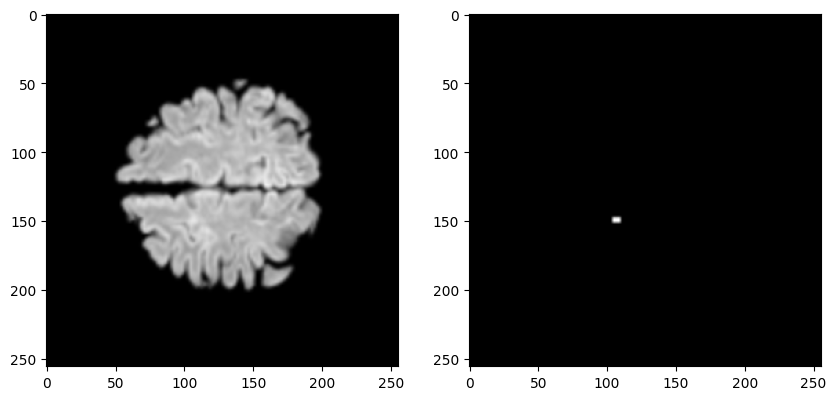

In [ ]:
i ,m = next(dataiter)

print(i.shape, m.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].imshow(i[0].permute(1, 2, 0))  # تصویر
axes[1].imshow(m[0][0], cmap='gray')  # ماسک
plt.show()

In [ ]:
del try_dataloader
del try_dataset
#del concatenated
#del c_img

In [ ]:
train_dataset = SegmentDataset(df_train, mask_color='GRAY')

In [ ]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=batch_size)

#net = MRI_Seg().to(device)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
len(train_dataloader)

252

torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


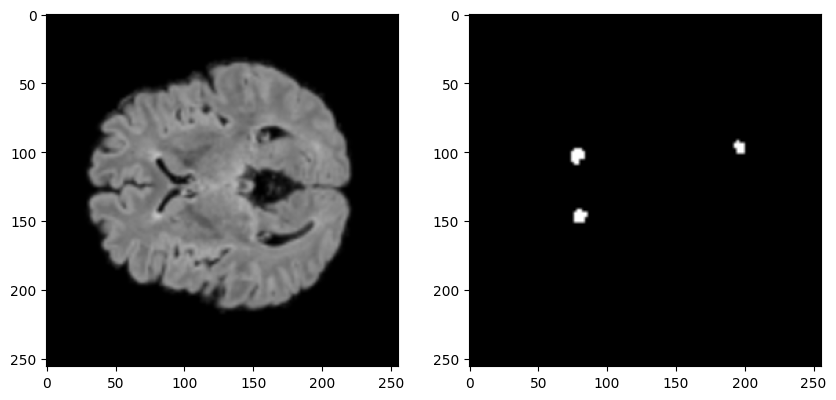

In [ ]:
dataiter = iter(train_dataloader)




i ,m = next(dataiter)

print(i.shape, m.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].imshow(i[0].permute(1, 2, 0))  # تصویر
axes[1].imshow(m[0], cmap='gray')  # ماسک
plt.show()

In [ ]:
import torch.nn.functional as F


In [ ]:
summary(model=net, input_size=(1, 3, 256, 256), col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
Unet                                          [1, 3, 256, 256]          [1, 1, 256, 256]          --                        True
├─InConv: 1-1                                 [1, 3, 256, 256]          [1, 64, 256, 256]         --                        True
│    └─DoubleConv: 2-1                        [1, 3, 256, 256]          [1, 64, 256, 256]         --                        True
│    │    └─Sequential: 3-1                   [1, 3, 256, 256]          [1, 64, 256, 256]         38,976                    True
├─Down: 1-2                                   [1, 64, 256, 256]         [1, 128, 128, 128]        --                        True
│    └─Sequential: 2-2                        [1, 64, 256, 256]         [1, 128, 128, 128]        --                        True
│    │    └─MaxPool2d: 3-2                    [1, 64, 256, 256]         [1, 64, 128, 128]   

In [ ]:
net.eval().to(device)

Unet(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(

Output shape: torch.Size([16, 1, 256, 256])
Target shape: torch.Size([16, 1, 256, 256])
Max value in target: 1.0
Loss: 0.6368024349212646


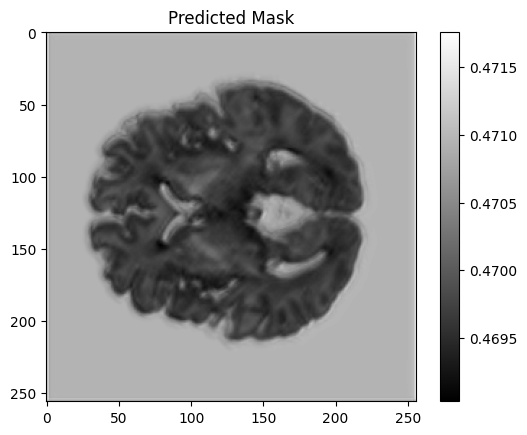

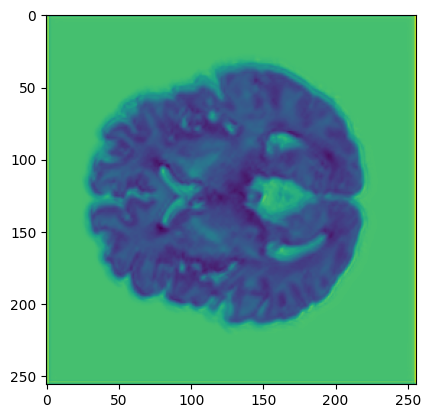

In [ ]:
inputs = i.to(device)  # تصاویر ورودی
targets = m.to(device)  # ماسک‌ها
out = net(inputs)
targets = targets.unsqueeze(1)
print("Output shape:", out.shape)
print("Target shape:", targets.shape)

# بررسی حداکثر مقدار ماسک هدف
print("Max value in target:", targets.max().item())
# محاسبه Loss
ls = criterion(out, targets)
print("Loss:", ls.item())


#ls = criterion(out[0], Variable(y[0]).to(device))

#print(ls)

plt.imshow(out[0].cpu().detach().numpy()[0], cmap='gray')
plt.title("Predicted Mask")
plt.colorbar()
plt.show()
plt.imshow(out[0].cpu().detach().numpy()[0])
del out

In [ ]:
def train_net():
    num_iter = len(train_dataloader)
    ep_init = 0

    for epoch in range(ep_init, ep_num):
        sum_loss = 0
        print(f"Epoch number: {epoch}")

        for i, data in enumerate(train_dataloader, 0):
            # Extract input tensors from data
            inputs, targets = data

            # Move data to device
            inputs = inputs.to(device)
            targets = targets.unsqueeze(1).to(device)  # Ensure target has the same shape as output

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss for reporting
            sum_loss += loss.item()

            # Print progress every 10 iterations
            if i % 10 == 0:
                avg_loss = sum_loss / (i + 1)
                print(f"Iteration {i}, Average Loss: {avg_loss:.6f}")
        torch.cuda.empty_cache()

        # Print epoch statistics
        avg_loss_epoch = sum_loss / num_iter
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}, Num Iterations: {num_iter}, Learning Rate: {lr}, Average Loss: {avg_loss_epoch:.6f}")

        # Save model checkpoint
        torch.save(net, FILE_NAME + '_{}'.format(epoch + 1))
    # Save final model
    torch.save(net, FILE_NAME)
    print("Training complete. The model has been saved.")


In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [ ]:
if use_pre_trained is False:
    net.train().to(device)
    train_net()

Epoch number: 0
Iteration 0, Average Loss: 0.042732
Iteration 10, Average Loss: 0.041900
Iteration 20, Average Loss: 0.042203
Iteration 30, Average Loss: 0.042007
Iteration 40, Average Loss: 0.041850
Iteration 50, Average Loss: 0.041607
Iteration 60, Average Loss: 0.041368
Iteration 70, Average Loss: 0.041141
Iteration 80, Average Loss: 0.040886
Iteration 90, Average Loss: 0.040681
Iteration 100, Average Loss: 0.040402
Iteration 110, Average Loss: 0.040156
Iteration 120, Average Loss: 0.039959
Iteration 130, Average Loss: 0.039728
Iteration 140, Average Loss: 0.039506
Iteration 150, Average Loss: 0.039323
Iteration 160, Average Loss: 0.039152
Iteration 170, Average Loss: 0.038939
Iteration 180, Average Loss: 0.038764
Iteration 190, Average Loss: 0.038540
Iteration 200, Average Loss: 0.038360
Iteration 210, Average Loss: 0.038157
Iteration 220, Average Loss: 0.037954
Iteration 230, Average Loss: 0.037754
Iteration 240, Average Loss: 0.037548
Iteration 250, Average Loss: 0.037376
Epoch 0

In [ ]:
def calc_rect(img_mask):
    ind = np.argwhere(img_mask >= 0.5)
    if len(ind) == 0:
        return None, None
    top_y = min(ind[:,0])
    bottom_y = max(ind[:,0])
    top_x = min(ind[:,1])
    bottom_x = max(ind[:,1])
    return (top_x, top_y), (bottom_x, bottom_y)

def show_results(inputs, targets, net,device, im_id):
    inputs = inputs.to(device)
    pred = net(inputs)
    pr = pred[im_id].cpu().detach().numpy().squeeze()


    xim = copy.deepcopy(inputs[im_id].permute(1, 2, 0).cpu().detach().numpy())
    xim = (xim * 255).astype(np.uint8)  # تبدیل به uint8
    r_size = 256  # تعریف اندازه
    # just to transform numpy array to cv2 image:
    xim = cv2.resize(xim, (r_size, r_size))
    top_left, bottom_right = calc_rect(pr)
    if top_left is not None:
        cv2.rectangle(xim, top_left, bottom_right, (255, 0, 0), 2)
    print(targets.shape)
    print(pr.shape)
    print(xim.shape)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(targets[im_id].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Ground Truth")
    axes[1].imshow(pr > 0.5, cmap="gray")
    axes[1].set_title("Predicted Mask")

    axes[2].imshow(xim/255)
    axes[2].set_title("Input Image with Bounding Box")

    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [ ]:
if use_pre_trained:
   # del net
    map_location=torch.device('cpu')
    net = torch.load(FILE_NAME_PR, map_location=torch.device('cpu'))
    print("The pre-trained model loaded")

In [ ]:
net.eval().to(device)

Unet(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'




In [ ]:
device = torch.device("cpu")
net.to(device)


Unet(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(

In [ ]:
print(i.shape)

torch.Size([16, 3, 256, 256])


In [ ]:
print(m.shape)

torch.Size([16, 256, 256])


torch.Size([1, 256, 256])
(256, 256)
(256, 256, 3)


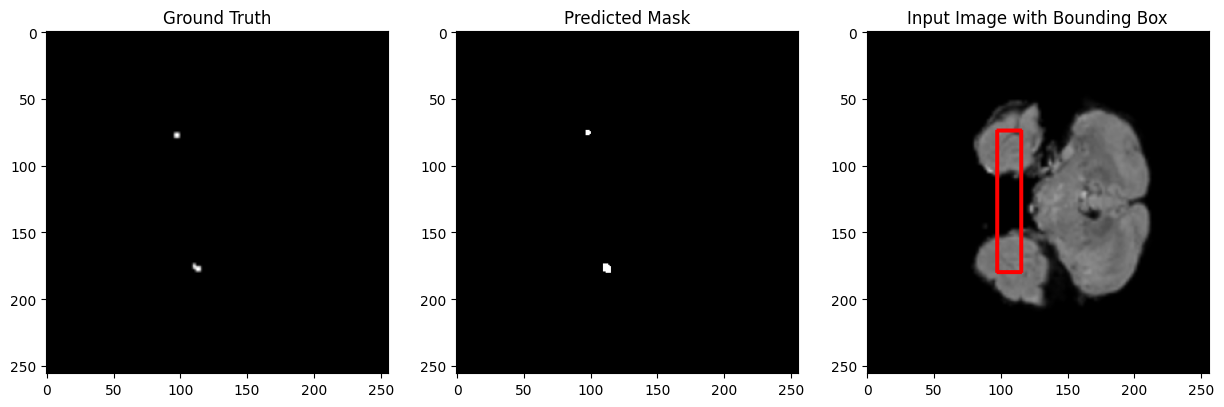

In [ ]:
show_results(i,m,net,device, 0)

In [ ]:
test_dataloader1 = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)

test_dataset = SegmentDataset(df_test)
test_dataloader2 = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)

In [ ]:
dataiter = iter(test_dataloader1)

torch.Size([1, 256, 256])
(256, 256)
(256, 256, 3)


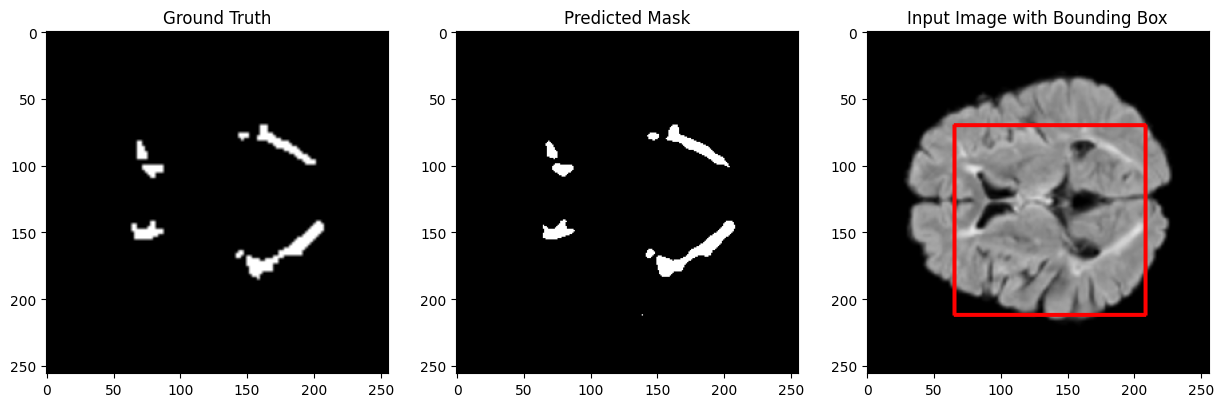

In [ ]:
i,m = next(dataiter)
show_results(i,m,net,device, 0)

In [ ]:
def calc_accuracy(test_dataloader, set_id, model, sample_num=None):
    batch_size = 1
    if not sample_num:
        N = len(test_dataloader)
    else:
        if sample_num <= 0:
            sample_num = len(test_dataloader)
        N = min(sample_num, len(test_dataloader))

    And = 0
    Uni = 0
    Uni_dice = 0

    T0 = 0
    T1 = 0
    F0 = 0
    F1 = 0

    for i, data in enumerate(test_dataloader, 0):
        #xx, yy, xs = data
        img, y = data

        # x0 = Variable(img0).to(device)
        # x1 = Variable(img1).to(device)
        # x2 = Variable(img2).to(device)
        # x3 = Variable(img3).to(device)
        # x4 = Variable(img4).to(device)
        img = img.to(device)
        yy = y.to(device)
        xx1 = net(img)
        xx1 = xx1.cpu().detach().numpy()
        yy = yy.cpu().detach().numpy()
        xx1[xx1 >= 0.5 ] = 1
        xx1[xx1 < 0.5 ] = 0

        owl = np.sum(xx1*yy)
        And += owl
        a_uni_dice = np.sum(xx1 + yy)
        a_uni = a_uni_dice - owl
        Uni += a_uni
        Uni_dice += a_uni_dice

        if xx1.max() == 0 and yy.max() == 0:
            T0 += 1
        if xx1.max() == 1 and yy.max() == 1:
            T1 += 1
        if xx1.max() == 0 and yy.max() == 1:
            F0 += 1
        if xx1.max() == 1 and yy.max() == 0:
            F1 += 1

        print('{}:  i = {}, And = {}, Uni = {}'.format(set_id, i, And, Uni))

        if i >= int(N - 1):
            break

    IoU_av = And / Uni if Uni > 0 else 0
    Dice = 2*And / Uni_dice if Uni_dice > 0 else 0

    return  IoU_av, Dice, T0, T1, F0, F1


In [ ]:
IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr = calc_accuracy(test_dataloader1, 'train', net, sample_num=550)

train:  i = 0, And = 0.0, Uni = 0.0
train:  i = 1, And = 320.48236083984375, Uni = 497.51763916015625
train:  i = 2, And = 522.0706024169922, Uni = 893.9293823242188
train:  i = 3, And = 683.5960998535156, Uni = 1183.4038696289062
train:  i = 4, And = 723.3921813964844, Uni = 1247.6077880859375
train:  i = 5, And = 1055.1372985839844, Uni = 1812.8626708984375
train:  i = 6, And = 1055.1372985839844, Uni = 1812.8626708984375
train:  i = 7, And = 1055.1372985839844, Uni = 1812.8626708984375
train:  i = 8, And = 1290.0902404785156, Uni = 2145.9097290039062
train:  i = 9, And = 1290.0902404785156, Uni = 2173.9097290039062
train:  i = 10, And = 1290.0902404785156, Uni = 2176.9097290039062
train:  i = 11, And = 2101.698028564453, Uni = 3359.3019409179688
train:  i = 12, And = 2101.698028564453, Uni = 3361.3019409179688
train:  i = 13, And = 2101.698028564453, Uni = 3363.3019409179688
train:  i = 14, And = 2252.6117553710938, Uni = 3624.388214111328
train:  i = 15, And = 2252.6117553710938, U

In [ ]:
print('training set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr))

training set: IoU = 0.6800855654760922, Dice = 0.8095844405659702, True_0 = 110, True_1 = 287, False_0 = 3, False_1 = 150


In [ ]:
IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts = calc_accuracy(test_dataloader2, 'test', net)

test:  i = 0, And = 0.0, Uni = 2.0
test:  i = 1, And = 0.0, Uni = 117.0
test:  i = 2, And = 0.0, Uni = 358.0
test:  i = 3, And = 0.0, Uni = 366.0
test:  i = 4, And = 0.0, Uni = 368.0
test:  i = 5, And = 0.0, Uni = 368.0
test:  i = 6, And = 0.0, Uni = 368.0
test:  i = 7, And = 0.0, Uni = 368.0
test:  i = 8, And = 0.0, Uni = 368.0
test:  i = 9, And = 0.0, Uni = 368.0
test:  i = 10, And = 0.0, Uni = 370.0
test:  i = 11, And = 0.0, Uni = 372.0
test:  i = 12, And = 0.0, Uni = 460.0
test:  i = 13, And = 0.0, Uni = 462.0
test:  i = 14, And = 0.0, Uni = 462.0
test:  i = 15, And = 0.0, Uni = 464.0
test:  i = 16, And = 0.0, Uni = 466.0
test:  i = 17, And = 0.0, Uni = 470.0
test:  i = 18, And = 0.0, Uni = 508.0
test:  i = 19, And = 0.0, Uni = 508.0
test:  i = 20, And = 0.0, Uni = 510.0
test:  i = 21, And = 0.0, Uni = 512.0
test:  i = 22, And = 0.0, Uni = 514.0
test:  i = 23, And = 0.0, Uni = 516.0
test:  i = 24, And = 0.0, Uni = 516.0
test:  i = 25, And = 0.0, Uni = 516.0
test:  i = 26, And = 0.0

In [ ]:
print('test set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts))

test set: IoU = 0.6427667051732304, Dice = 0.7825416752808472, True_0 = 91, True_1 = 155, False_0 = 2, False_1 = 133
